Starting agian rather than re-interpret old work

In [53]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
import astropy.constants as const

from astropy.modeling import models, fitting
from astropy.timeseries import LombScargle

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [54]:
wddvs = Table.read('dv_lists/wd_dvs.ecsv')
mddvs = Table.read('dv_lists/bd_dvs.ecsv')

In [55]:
wdti, wdvi, wdei = np.array(wddvs['MJD'])*24, np.array(wddvs['VELOCITY']), np.array(wddvs['ERROR'])
mdti, mdvi, mdei = np.array(mddvs['MJD'])*24, np.array(mddvs['VELOCITY']), np.array(mddvs['ERROR'])


In [56]:
nclip = 4 #removing first 4 points to remove old data
wdt, wdv, wde = wdti[nclip:], wdvi[nclip:], wdei[nclip:]
mdt, mdv, mde = mdti[nclip:], mdvi[nclip:], mdei[nclip:]
# print(wdt[0]/24, mdt[0]/24)


4.226024552371193
5.150305601040683


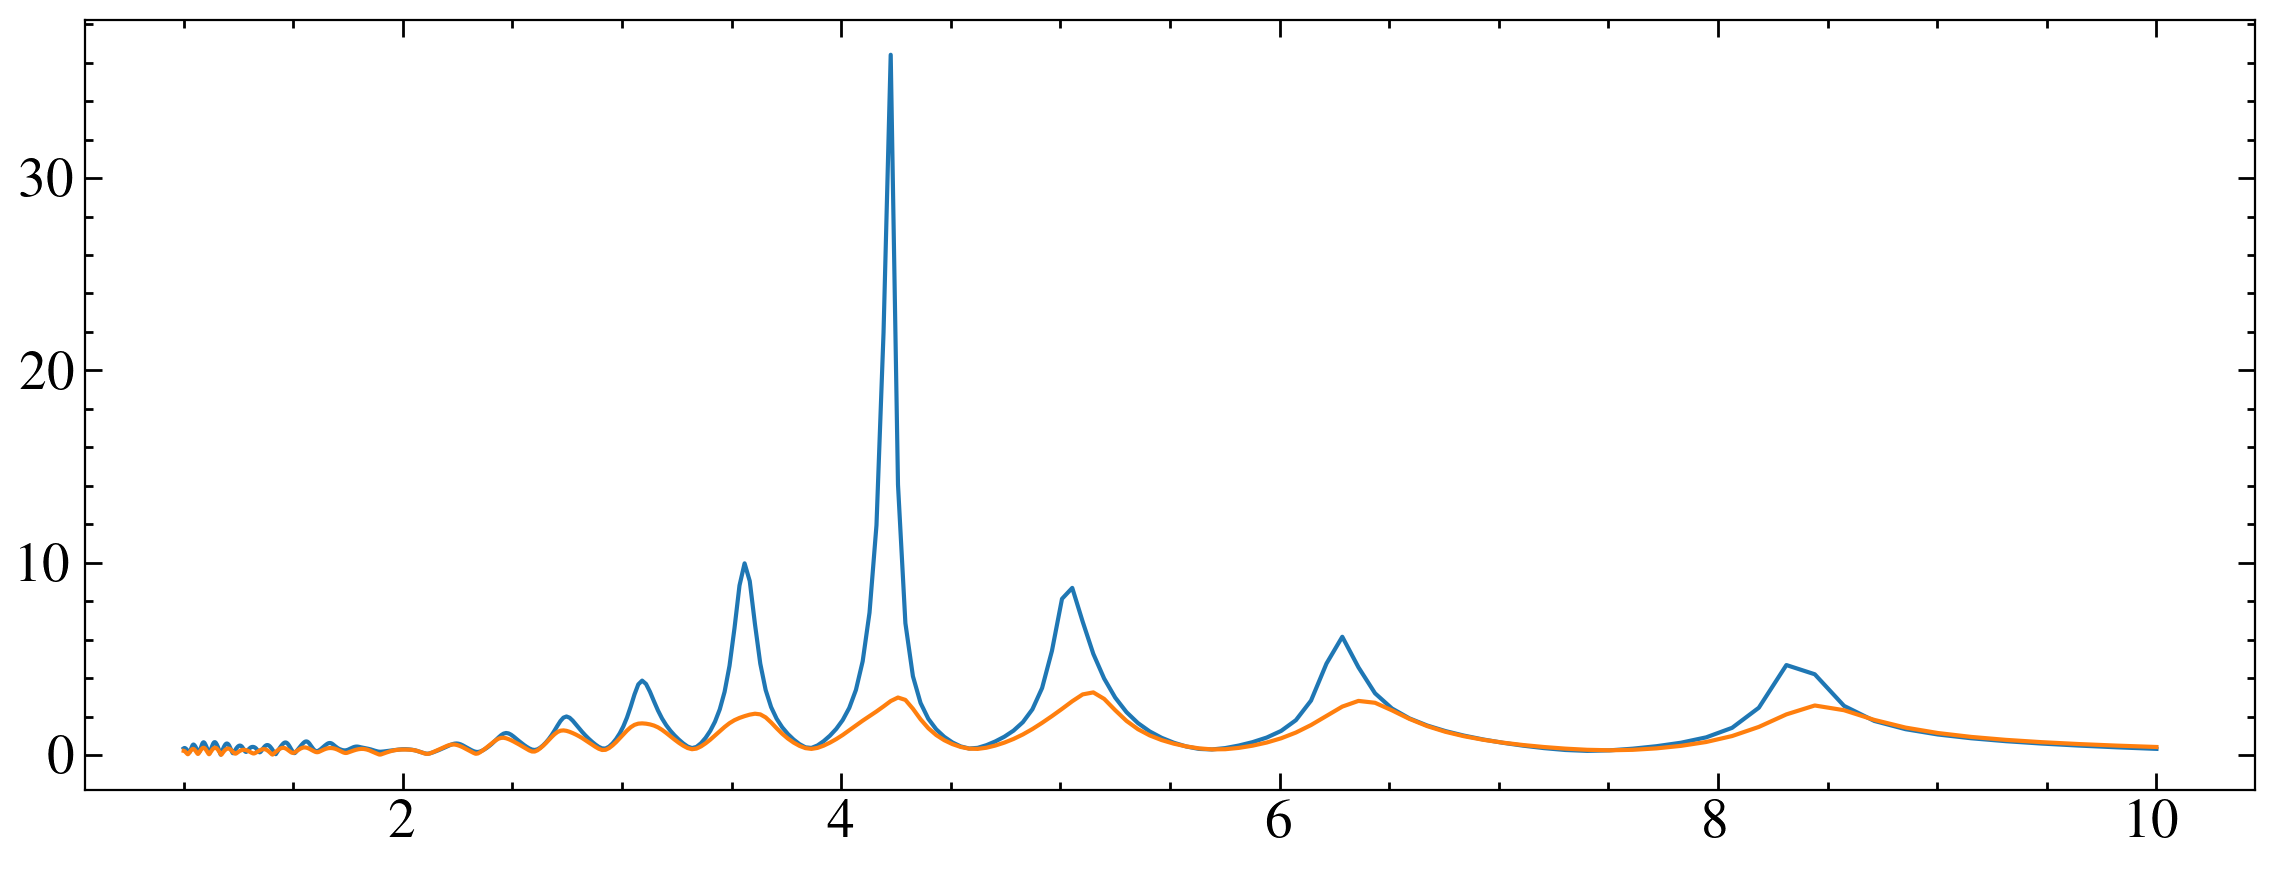

In [57]:
#companion first

frequency, power = LombScargle(mdt, mdv, normalization='model').autopower(minimum_frequency=1/10, maximum_frequency=1/1, samples_per_peak=20)
frequency_wd, power_wd = LombScargle(wdt, wdv, normalization='model').autopower(minimum_frequency=1/10, maximum_frequency=1/1, samples_per_peak=20)

fig, ax = plt.subplots()

ax.plot(1/frequency, power**0.5)
ax.plot(1/frequency_wd, power_wd**0.5)

period = 1/frequency[np.argmax(power)]
print(period)

period_wd = 1/frequency_wd[np.argmax(power_wd)]
print(period_wd)

# ls = LombScargle(mdt, mdv, normalization='model')
# probabilities = [0.1, 0.05, 0.01]
# ls.false_alarm_level(probabilities)  

In [186]:
# fig, ax = plt.subplots()

# t0 =  mdt[0]

# ax.errorbar(mdt, mdv, yerr=mde, ls='none', marker='o')

# fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)

# mod_init = models.Sine1D(amplitude = 200, frequency = 1/period, phase =0) + models.Const1D(60)

# mod_fit = fitter(mod_init, mdt, mdv, weights=1/mde, maxiter=1000000)
# # fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

# # timefit = np.linspace(-5, 30, 1000)
# timefit = np.linspace(mdt[0], mdt[-1], 10000)
# ax.plot(timefit, mod_fit[0](timefit))

# print(mod_fit)
# print(1/mod_fit.frequency_0, mod_fit.stds['frequency_0']/mod_fit.frequency_0**2)


# # eph = ((mod_fit[0].phase+0.25)/mod_fit.frequency_0)+mdt[0]+(235/mod_fit.frequency_0)
# # plt.axvline(eph)
# # print(fit_e)
# # print(mod_fit.stds)

# #fit_mod.stds['intercept'],

try to fit the wd dvs with joint fitter

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=-198.09469519, frequency=0.23679352, phase=0.29864733)>

    [1]: <Const1D(amplitude=28.12566111)>
Parameters:
       amplitude_0         frequency_0           phase_0          amplitude_1    
    ------------------ ------------------- ------------------- ------------------
    -198.0946951878368 0.23679351859772912 0.29864732876463135 28.125661110879076
4.223088562228874 0.0033582023349523595
p, ph 4.223088562228874 0.29864732876463135
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=-34.22801645, frequency=0.23436533, phase=-0.14922529)>

    [1]: <Const1D(amplitude=59.62185487)>
Parameters:
       amplitude_0         frequency_0           phase_0          amplitude_1    
    ------------------ ------------------- ------------------- ------------------
    -34.228016447102

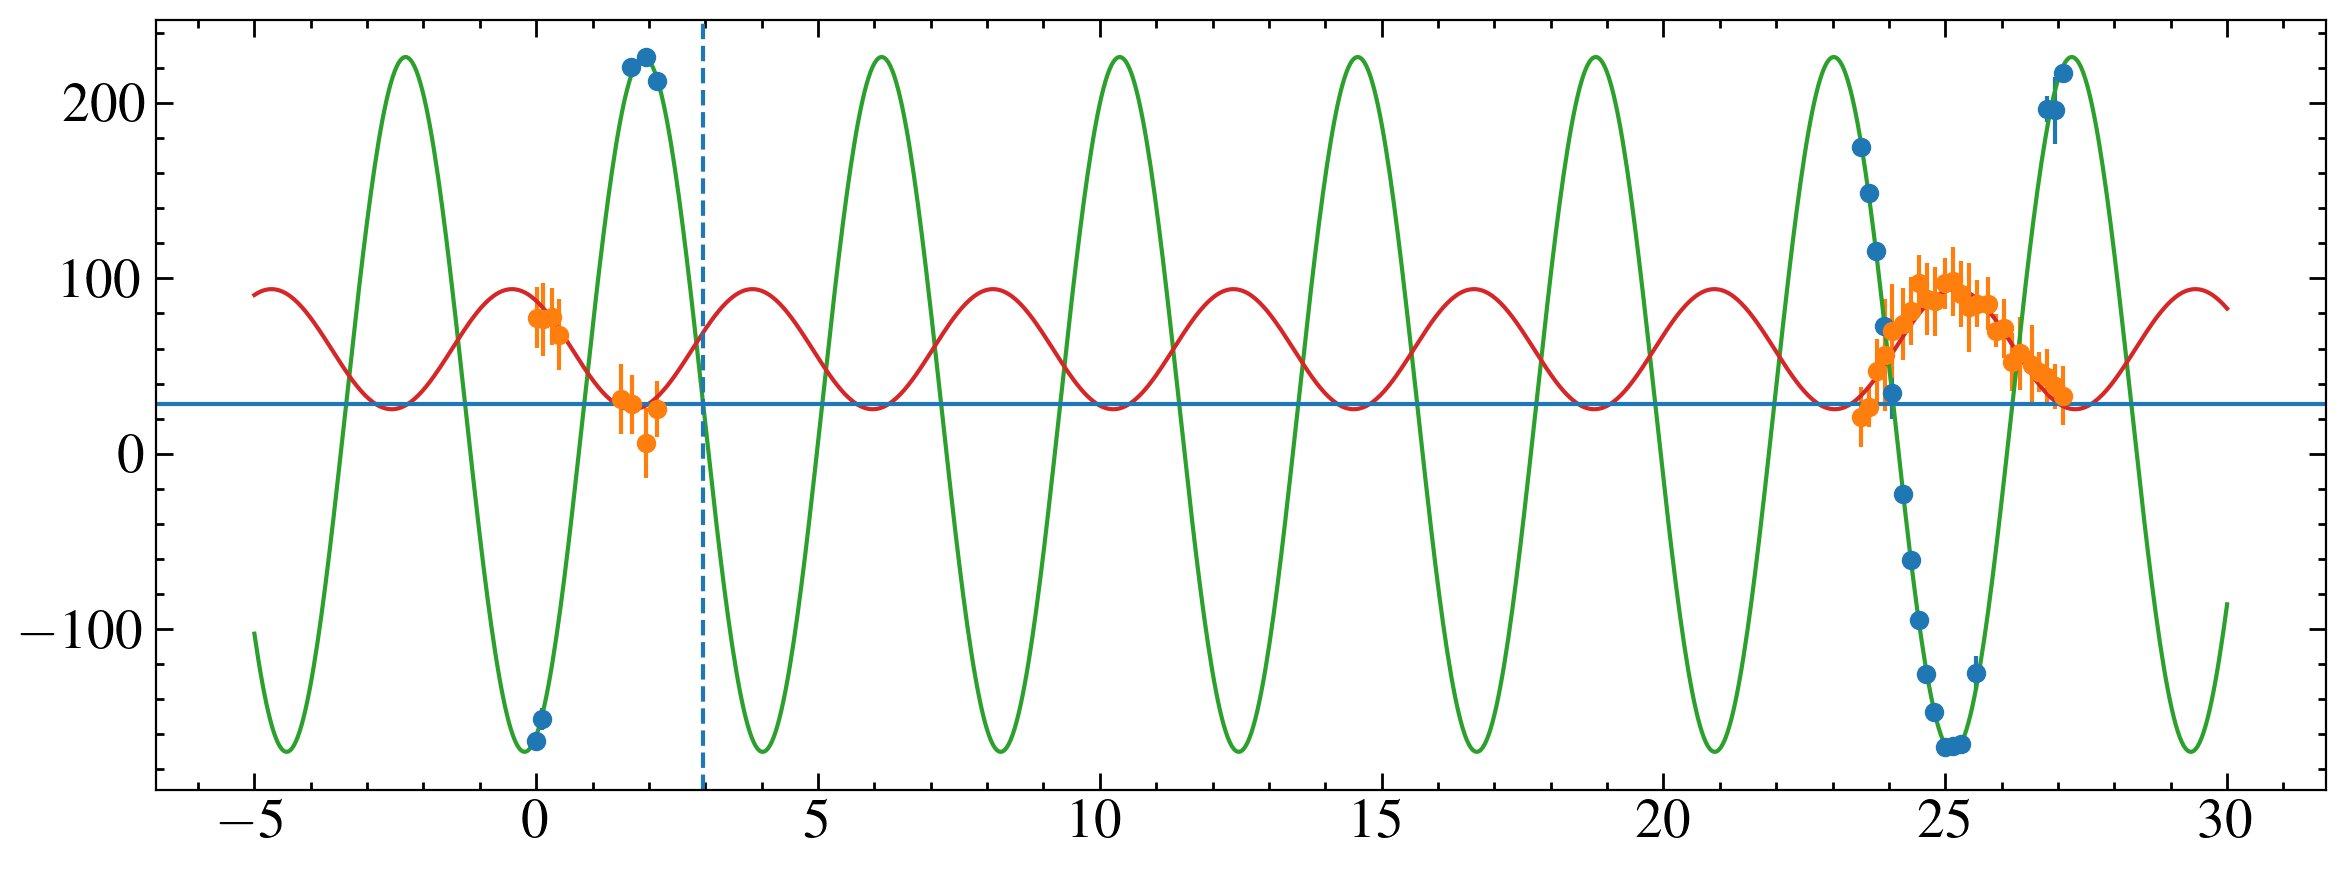

In [200]:
fig, ax = plt.subplots()

t0 = mdt[0]

ax.errorbar(mdt-t0, mdv, yerr=mde, ls='none', marker='o')
ax.errorbar(wdt-t0, wdv, yerr=wde, ls='none', marker='o')



# fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)

mod_md = models.Sine1D(amplitude = 200, frequency = 1/period, phase =0.5) + models.Const1D(30)
mod_wd = models.Sine1D(amplitude = -40, frequency = 1/period, phase =0.0) + models.Const1D(60)

timefit = np.linspace(-5, 30, 1000)

md_fit = fitter(mod_md, mdt-t0, mdv, weights=1/mde, maxiter=10000)

ax.plot(timefit, md_fit(timefit))

print(md_fit)
print(1/md_fit.frequency_0, md_fit.stds['frequency_0']/md_fit.frequency_0**2)

fit_period = 1/md_fit.frequency_0
fit_period_error = md_fit.stds['frequency_0']/md_fit.frequency_0**2
fit_phase = md_fit.phase_0
print('p, ph', fit_period, fit_phase.value)

wd_fit = fitter(mod_wd, wdt-t0, wdv, weights=1/wde, maxiter=1000)

ax.plot(timefit, wd_fit(timefit))

print(wd_fit)
print(1/wd_fit.frequency_0, wd_fit.stds['frequency_0']/wd_fit.frequency_0**2)


# eph = t0 + (fit_period*fit_phase)
# print(eph)

# fit_joint = fitting.JointFitter([mod_md, mod_wd], {mod_md: ["frequency_0", "phase_0"], mod_wd: ["frequency_0", "phase_0"]}, [1/period,0])
# fit_joint = fitting.JointFitter([mod_md, mod_wd], {mod_md: ["frequency_0"], mod_wd: ["frequency_0"]}, [1/period])


# mod_fit = fit_joint((mdt-t0), mdv, (wdt-t0), wdv)
# mod_fit = fitter(mod_init, mdt-t0, mdv, weights=1/mde, maxiter=1000)
# # fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

# timefit = np.linspace(-5, 30, 1000)
# ax.plot(timefit, mod_fit(timefit))

# print(mod_fit)
# print(1/mod_fit.frequency_0, mod_fit.stds['frequency_0']/mod_fit.frequency_0**2)

eph = fit_period*(1-fit_phase)
print (eph, eph+t0, (eph+t0)/24)
ax.axvline(eph, ls='--')
ax.axhline(md_fit[1].amplitude.value)
# ax.axvline(fit_phase.value, ls='-.')

Joint fitter not working but the wd fit looks approximatly correct, fold onto M dwarf period and refit.

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=-198.09469519, frequency=1., phase=0.5)>

    [1]: <Const1D(amplitude=28.12566111)>
Parameters:
        amplitude_0     frequency_0 phase_0    amplitude_1    
    ------------------- ----------- ------- ------------------
    -198.09469518929603         1.0     0.5 28.125661111730295
standard deviations
amplitude_0| 0.454
amplitude_1| 0.282
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=-32.86093915, frequency=1., phase=0.)>

    [1]: <Const1D(amplitude=59.5401497)>
Parameters:
       amplitude_0     frequency_0 phase_0    amplitude_1    
    ------------------ ----------- ------- ------------------
    -32.86093915141344         1.0     0.0 59.540149702079184
standard deviations
amplitude_0| 3.997
amplitude_1| 2.881


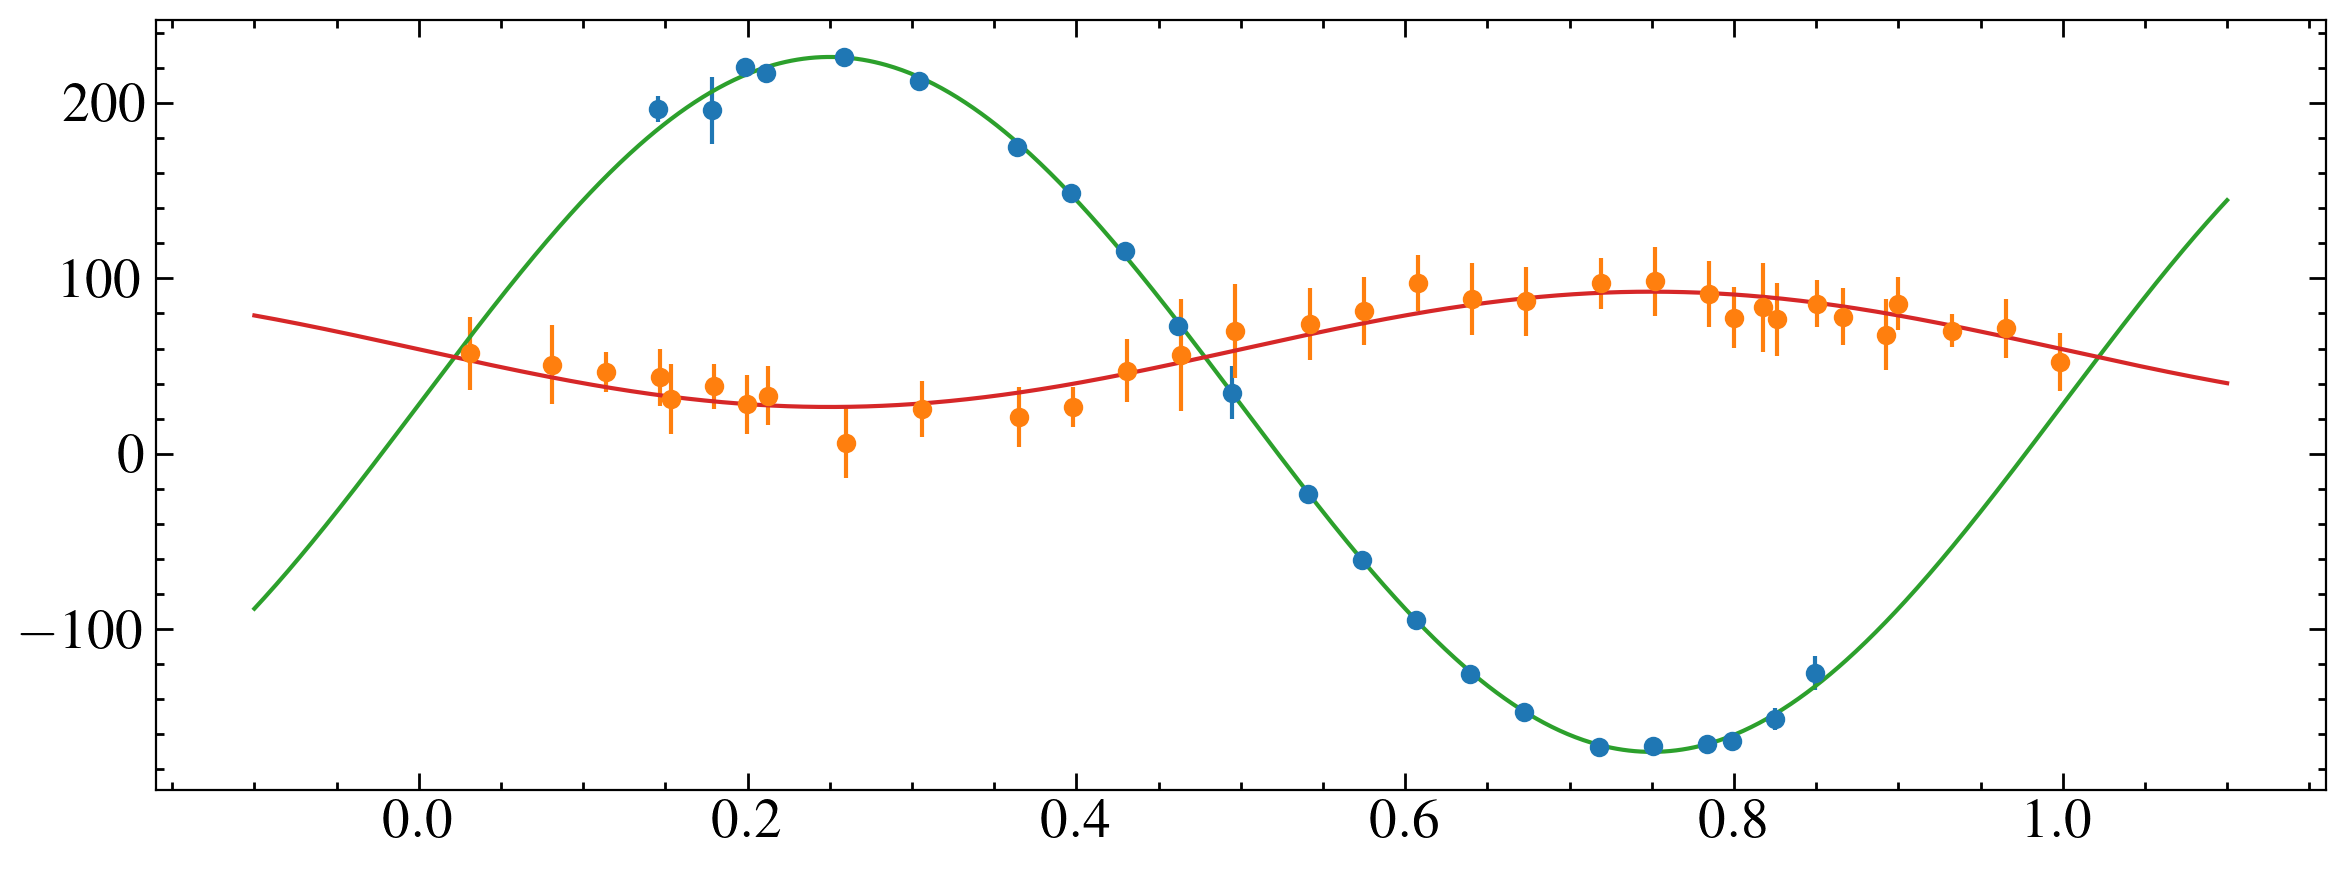

In [87]:
fig, ax = plt.subplots()

# t0 = mdt[0]

mdtf = ((mdt-t0 + (fit_period*(fit_phase+0.5)))/fit_period)  % 1 
wdtf = ((wdt-t0 + (fit_period*(fit_phase+0.5)))/fit_period)  % 1 

# print(wdtf[0])

ax.errorbar(mdtf, mdv, yerr=mde, ls='none', marker='o')
ax.errorbar(wdtf, wdv, yerr=wde, ls='none', marker='o')



# fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)

mod_md = models.Sine1D(amplitude = 200, frequency = 1, phase =0.5, fixed=dict(frequency=True, phase=True)) + models.Const1D(30)
mod_wd = models.Sine1D(amplitude = 40, frequency = 1, phase =0.0, fixed=dict(frequency=True,  phase=True)) + models.Const1D(60)



timefit = np.linspace(-0.1, 1.1, 1000)

md_fit = fitter(mod_md, mdtf, mdv, weights=1/mde, maxiter=1000)

ax.plot(timefit, md_fit(timefit))

print(md_fit)
print(md_fit.stds)
# print(1/md_fit.frequency_0, md_fit.stds['frequency_0']/md_fit.frequency_0**2)


wd_fit = fitter(mod_wd, wdtf, wdv, weights=1/wde, maxiter=1000)

ax.plot(timefit, wd_fit(timefit))

print(wd_fit)
print(wd_fit.stds)
# print(1/wd_fit.frequency_0, wd_fit.stds['frequency_0']/wd_fit.frequency_0**2)

# ax.axhline(md_fit.amplitude_1.value)
# ax.axhline(wd_fit.amplitude_1.value)
# ax.axvline(0.5)

# print(mdtf)

<ErrorbarContainer object of 3 artists>

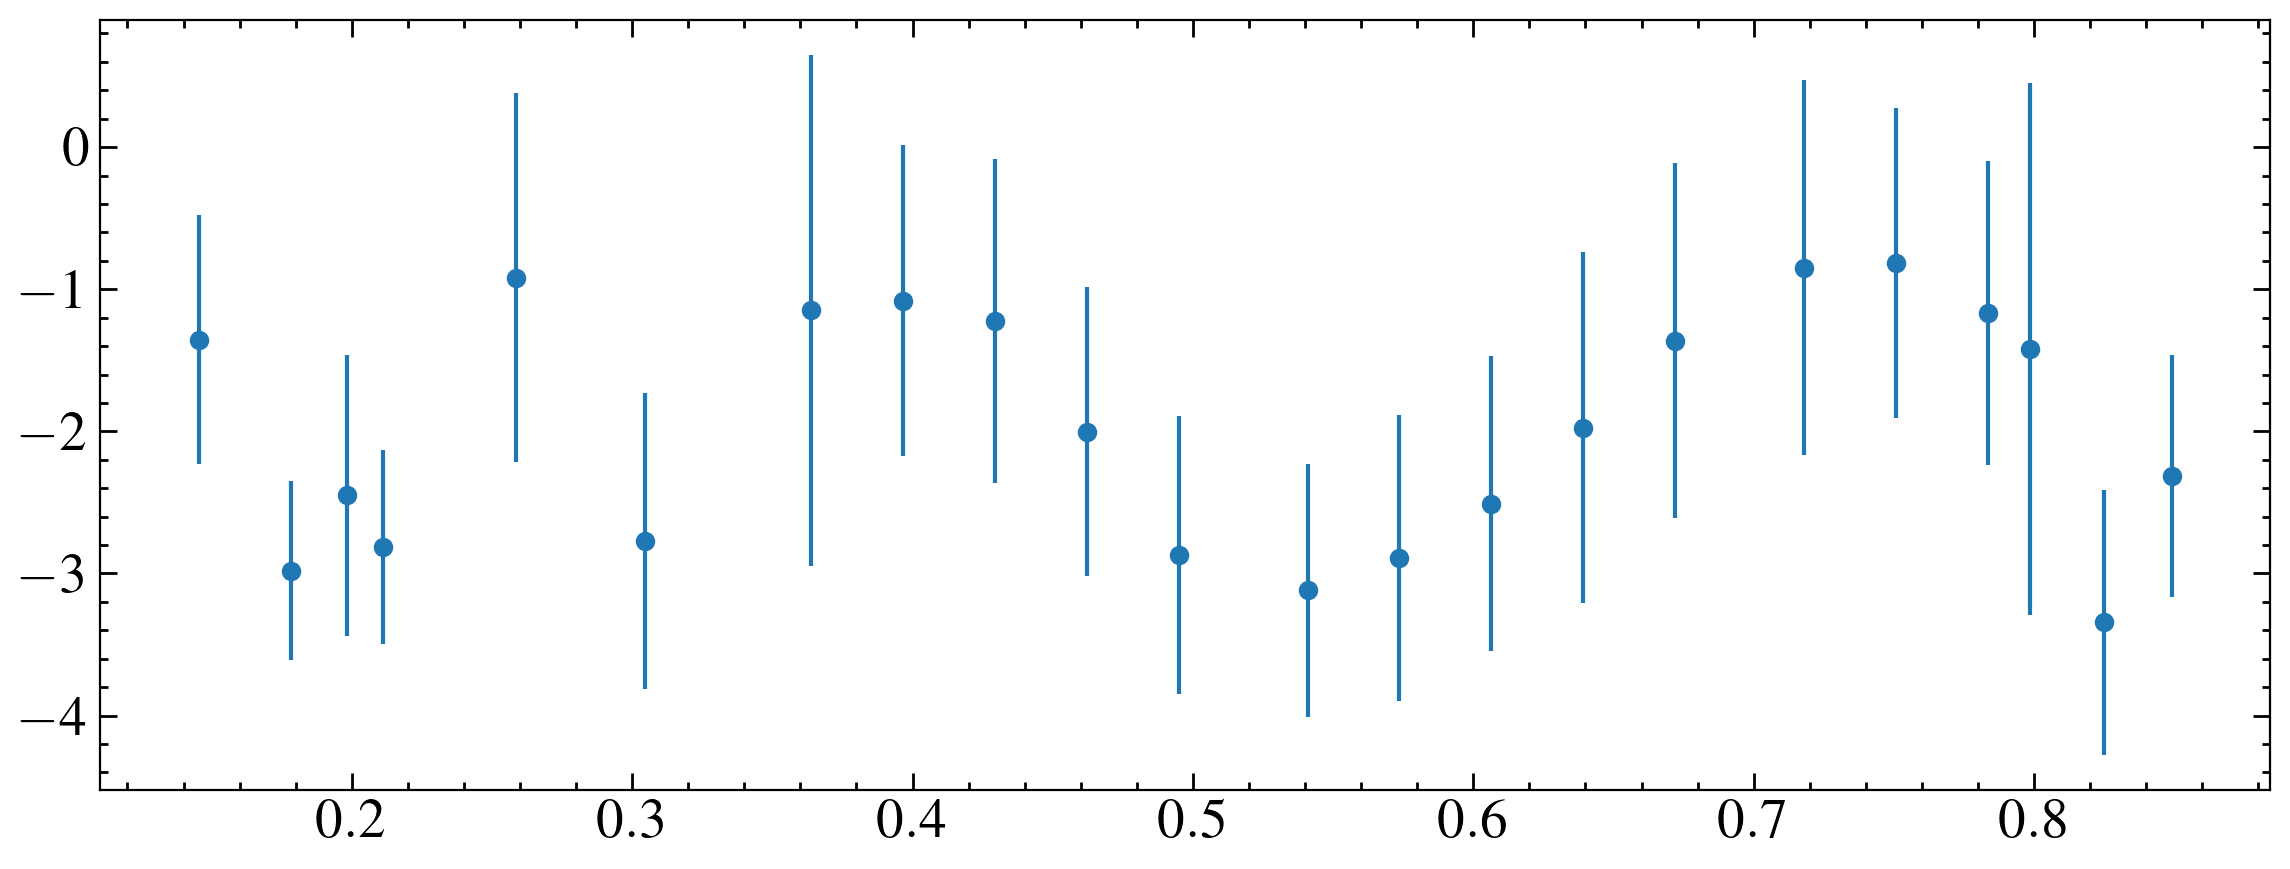

In [88]:
ew, ewe = mddvs['EW'][4:], mddvs['EW_ERR'][4:]

plt.errorbar(mdtf, ew, yerr=ewe, ls='none', marker='o')

<>:43: SyntaxWarning: invalid escape sequence '\,'
<>:44: SyntaxWarning: invalid escape sequence '\,'
<>:43: SyntaxWarning: invalid escape sequence '\,'
<>:44: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_23993/2558022277.py:43: SyntaxWarning: invalid escape sequence '\,'
  ax.set_xlabel('Phase (P = {:.4}\,h)'.format(fit_period))
/tmp/ipykernel_23993/2558022277.py:44: SyntaxWarning: invalid escape sequence '\,'
  ax.set_ylabel('Radial Velocity (km\,s$^{-1}$)')


Text(0, 0.5, 'Radial Velocity (km\\,s$^{-1}$)')

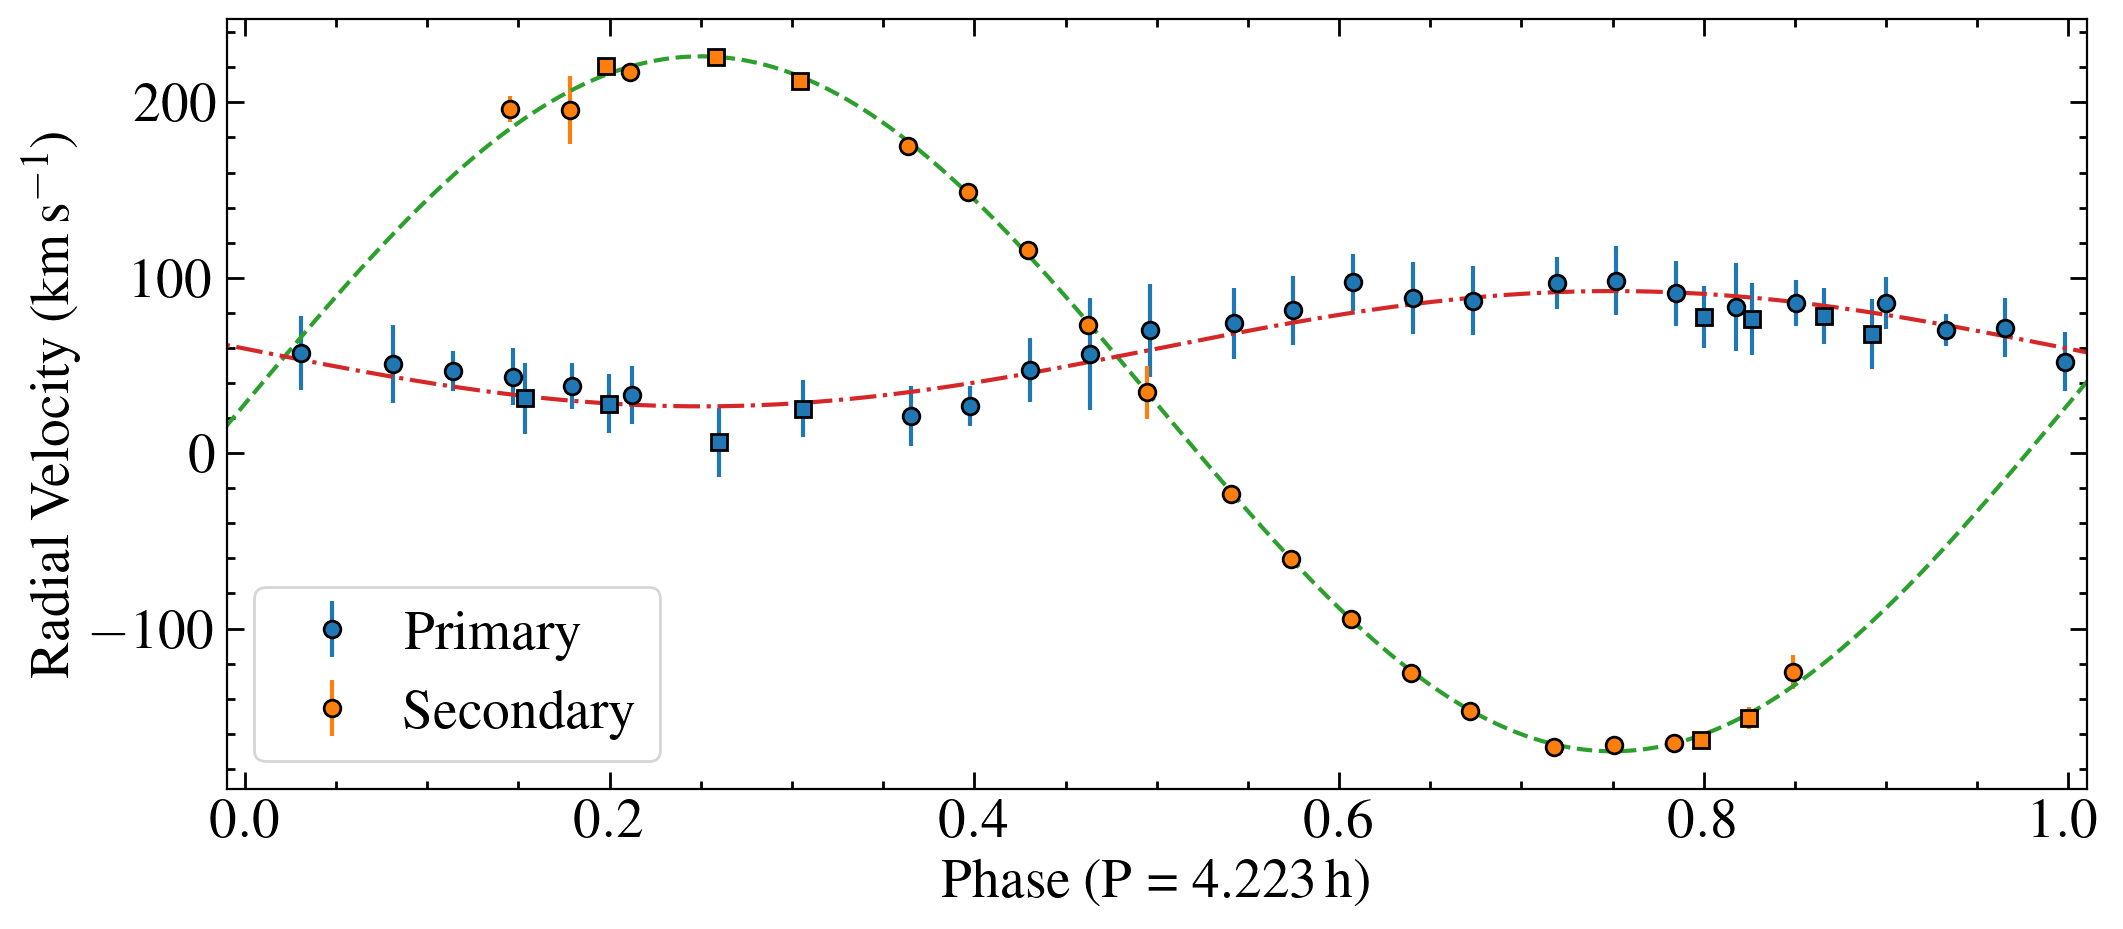

In [89]:
import math
def make_syms(data):
    dates  = np.array(data['MJD'])
    nights = np.array([math.floor(date) for date in dates])
    syms =  []
    symlist = ['h', 'p', 's', 'o']
    for i , n in enumerate(np.unique(nights)):
        for night in nights:
            if night == n:
                syms.append(symlist[i])
    return np.array(syms)

fig, ax = plt.subplots(figsize=(12, 5))



md_syms = make_syms(mddvs)[nclip:]
wd_syms = make_syms(wddvs)[nclip:]

for i in range(len(wdtf)):
     ax.errorbar(wdtf[i], wdv[i], yerr=wde[i], ls='none', marker=wd_syms[i], markeredgecolor='k', c='C0', label='Primary')
for i in range(len(mdtf)):
    ax.errorbar(mdtf[i], mdv[i], yerr=mde[i], ls='none', marker=md_syms[i], c='C1', markeredgecolor='k', label='Secondary')

    
ax.plot(timefit, md_fit(timefit), ls='--', c='C2')
ax.plot(timefit, wd_fit(timefit), ls='-.', c='C3')


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc=3, frameon=True)

ax.set_xlim(-0.01, 1.01)
# ax.set_xlim(0.001, 0.9999)

# ax2 = ax.twinx()
# args = np.argsort(mdtf)
# ax2.plot(mdtf[args], ew[args])
# ax2.set_ylim(0, -4)
# print(fit_phase)

ax.set_xlabel('Phase (P = {:.4}\,h)'.format(fit_period))
ax.set_ylabel('Radial Velocity (km\,s$^{-1}$)')

In [90]:
fit_period

np.float64(4.223088562228874)

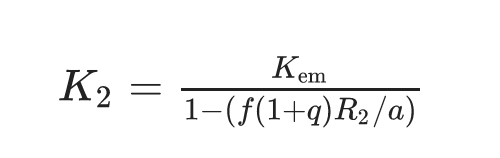

<>:29: SyntaxWarning: invalid escape sequence '\,'
<>:57: SyntaxWarning: invalid escape sequence '\p'
<>:58: SyntaxWarning: invalid escape sequence '\,'
<>:29: SyntaxWarning: invalid escape sequence '\,'
<>:57: SyntaxWarning: invalid escape sequence '\p'
<>:58: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_23993/1646820765.py:29: SyntaxWarning: invalid escape sequence '\,'
  ax[1].set_ylabel('Radial Velocity (km\,s$^{-1}$)')
/tmp/ipykernel_23993/1646820765.py:57: SyntaxWarning: invalid escape sequence '\p'
  ax[2].set_xlabel('Phase (P = {:.4}$\pm${:.1}\,h)'.format(fit_period, fit_period_error))
/tmp/ipykernel_23993/1646820765.py:58: SyntaxWarning: invalid escape sequence '\,'
  ax[2].set_ylabel('Radial Velocity (km\,s$^{-1}$)')


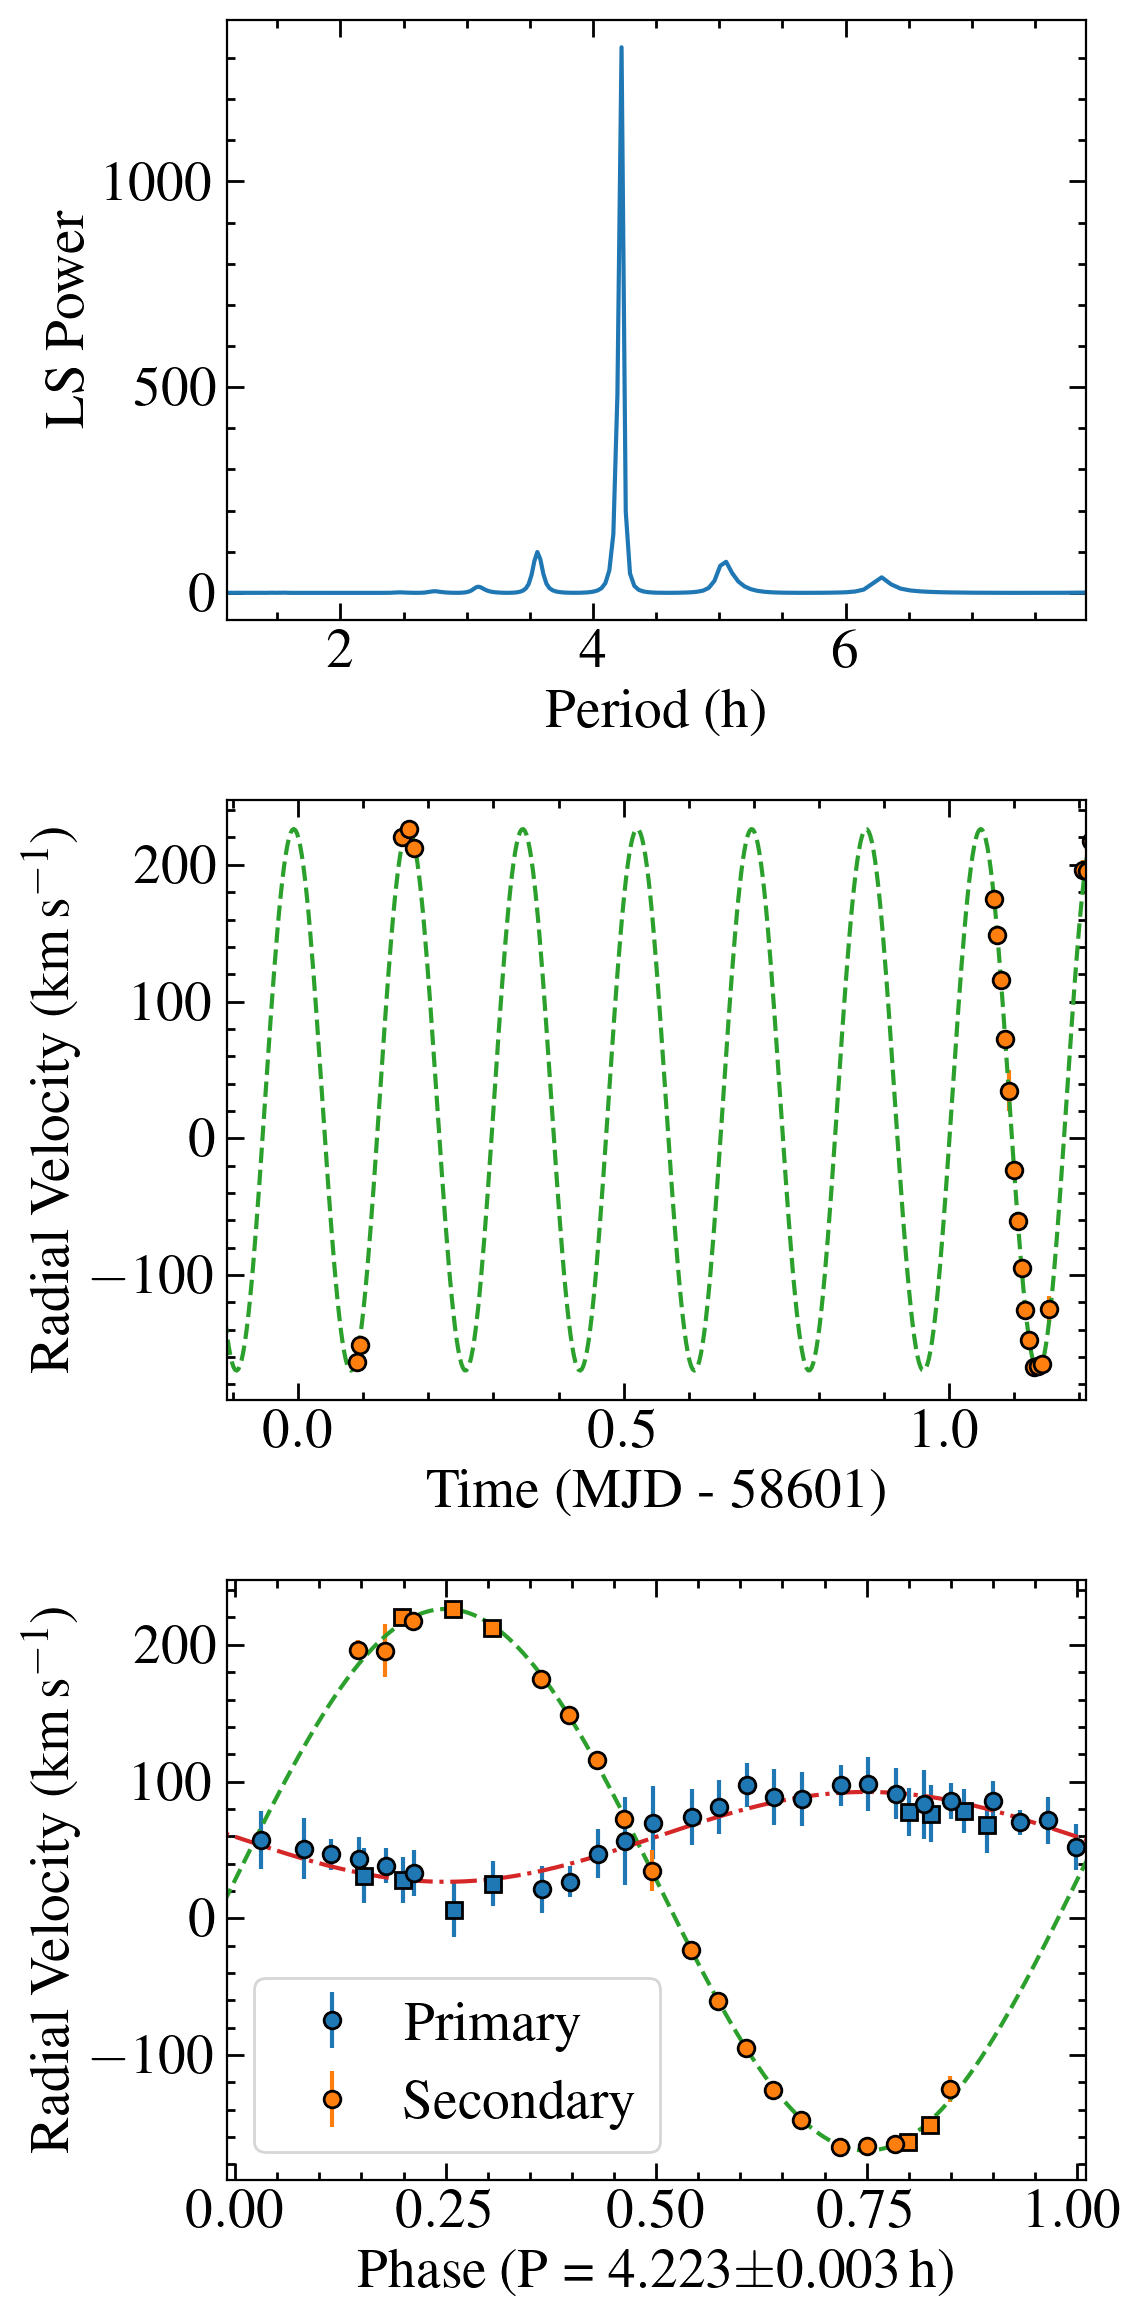

In [91]:
#plot of periodogram and fit

fig, ax = plt.subplots(nrows = 3, figsize=(6, 12))

#periodogram

ax[0].plot(1/frequency, power)
ax[0].set_xlim(1.1, 7.9)

ax[0].set_xlabel('Period (h)')
ax[0].set_ylabel('LS Power')


#fit
t0 = math.floor(mdt[0]/24) 
ax[1].errorbar((mdt/24)-t0, mdv, yerr=mde, ls='none', marker='o', c='C1', markeredgecolor='k')


day_init = models.Sine1D(amplitude = 200, frequency = 1/(period/24), phase =0) + models.Const1D(30)
day_fit = fitter(day_init, (mdt/24)-t0, mdv, weights=1/mde, maxiter=1000)

# timefit = np.linspace(-5, 30, 1000)

timefit = np.linspace(-0.5, 2, 1000)
ax[1].plot(timefit, day_fit(timefit), ls='--', c='C2')
ax[1].set_xlim(-0.11, 1.21)

ax[1].set_xlabel('Time (MJD - {})'.format(t0))
ax[1].set_ylabel('Radial Velocity (km\,s$^{-1}$)')

#folded
timefit = np.linspace(-0.1, 1.1, 1000)

for i in range(len(wdtf)):
     ax[2].errorbar(wdtf[i], wdv[i], yerr=wde[i], ls='none', marker=wd_syms[i], markeredgecolor='k', c='C0', label='Primary')
for i in range(len(mdtf)):
    ax[2].errorbar(mdtf[i], mdv[i], yerr=mde[i], ls='none', marker=md_syms[i], c='C1', markeredgecolor='k', label='Secondary')

    
ax[2].plot(timefit, md_fit(timefit), ls='--', c='C2')
ax[2].plot(timefit, wd_fit(timefit), ls='-.', c='C3')


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[2].legend(by_label.values(), by_label.keys(), loc=3, frameon=True)

ax[2].set_xlim(-0.01, 1.01)
# ax.set_xlim(0.001, 0.9999)

# ax2 = ax.twinx()
# args = np.argsort(mdtf)
# ax2.plot(mdtf[args], ew[args])
# ax2.set_ylim(0, -4)


ax[2].set_xlabel('Phase (P = {:.4}$\pm${:.1}\,h)'.format(fit_period, fit_period_error))
ax[2].set_ylabel('Radial Velocity (km\,s$^{-1}$)')


fig.tight_layout()

fig.savefig('plots/rv_fits.pdf')

In [92]:
print(md_fit)
print(wd_fit)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=-198.09469519, frequency=1., phase=0.5)>

    [1]: <Const1D(amplitude=28.12566111)>
Parameters:
        amplitude_0     frequency_0 phase_0    amplitude_1    
    ------------------- ----------- ------- ------------------
    -198.09469518929603         1.0     0.5 28.125661111730295
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=-32.86093915, frequency=1., phase=0.)>

    [1]: <Const1D(amplitude=59.5401497)>
Parameters:
       amplitude_0     frequency_0 phase_0    amplitude_1    
    ------------------ ----------- ------- ------------------
    -32.86093915141344         1.0     0.0 59.540149702079184


In [93]:
k1, k1e = abs(wd_fit.amplitude_0), wd_fit.stds['amplitude_0']
print('k1', k1, k1e)
g1, g1e = abs(wd_fit.amplitude_1), wd_fit.stds['amplitude_1']
print('g1', g1, g1e)

kem, keme = abs(md_fit.amplitude_0), md_fit.stds['amplitude_0']
print('kem', kem, keme)
gem, geme = abs(md_fit.amplitude_1), md_fit.stds['amplitude_1']
print('gem', gem, geme)


# print(1/md_fit.frequency_0, md_fit.stds['frequency_0']/md_fit.frequency_0**2)


k1 32.86093915141344 3.9971168042203296
g1 59.540149702079184 2.8811235226965928
kem 198.09469518929603 0.45354027077638814
gem 28.125661111730295 0.2821983697751815


Work out how to do the correction equation. Params from https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.3877G/abstract

20260204 Sneha fit
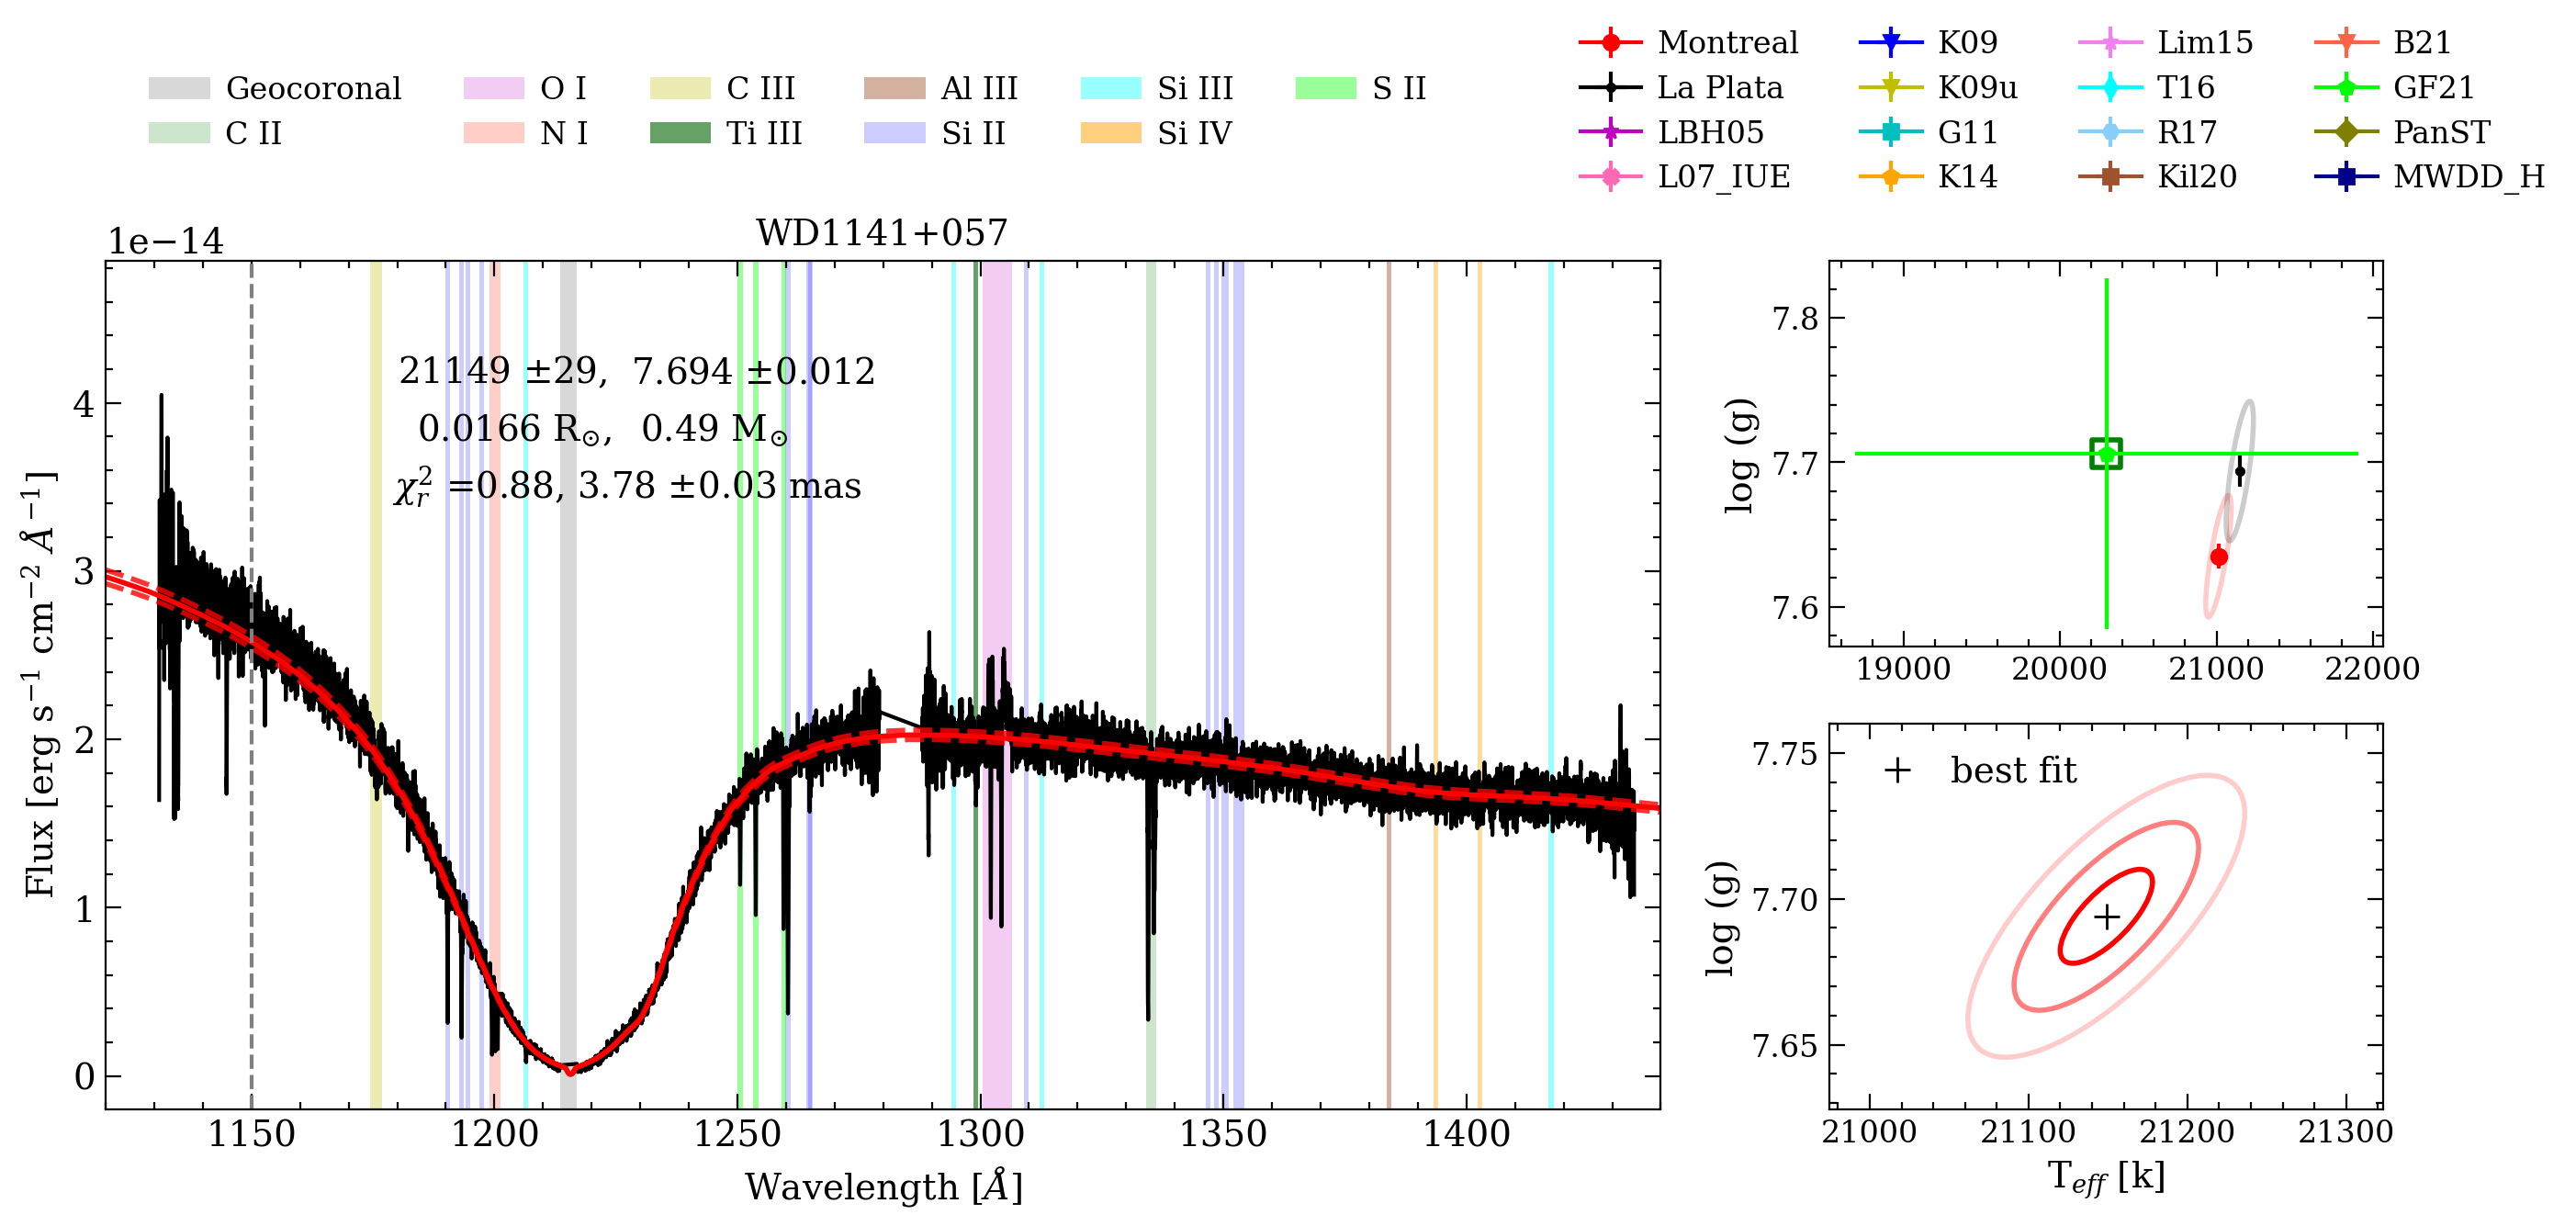

In [94]:
#nicola params
# teff, teffe = 20295.58, 1609.44
# logg, logge = 7.706178, 0.121429
# M1, M1e =  0.475735, 0.045966
# dist, diste = 264.25576800, np.mean([264.25576800-256.65420500,271.86544800-264.25576800])
# rwd = 0.0160
# print(dist, diste)

#sneha params 2026
teff, teffe = 21149, 29
logg, logge = 7.694, 0.012
M1, M1e =  0.49, 0.05 # asummed big e
dist, diste = 1000/3.78, (0.03*1000)/(3.78**2)
rwd = 0.0166

# print(dist, diste)

In [95]:
# M2/M1 = v1/v2 
maxM2 = (k1/kem) * M1
print (maxM2)
print ((maxM2*u.Msun).to(u.Mjup))

0.0812836515829256
85.14995030395036 jupiterMass


In [96]:
def mass_radius(mass, type='bd', error=False):
    """
    Mass radius relation from https://ui.adsabs.harvard.edu/abs/2017ApJ...834...17C/abstract
    """
    if type == 'bd':
        radius = mass ** -0.044
        edown = mass ** -(0.044 - 0.017)
        eup = mass ** -(0.044 + 0.019)
        error_array = np.sort([abs(radius -edown), abs(eup -radius)])
        
        # - 0.017, + 0.019
    if type == 'star':
        radius = mass ** 0.881
        edown = mass ** (0.881 - 0.024)
        eup = mass ** (0.881 + 0.025)
        error_array = np.sort([abs(radius -edown), abs(eup -radius)])
        # - 0.024, + 0.025
    if error:
        return radius, error_array
    else:
        return radius

# print(mass_radius((maxM2*u.Msun).to(u.Mjup).value, error=True))
# print(mass_radius((maxM2), error=True))
# print(mass_radius(maxM2, type='star', error=True))

rbd, rbd_e = mass_radius((maxM2*u.Msun).to(u.Mjup).value, error=True)
rbd,  rbd_e = ((rbd*u.Rjup).to(u.Rsun).value),  ((rbd_e*u.Rjup).to(u.Rsun)).value 
print(rbd, rbd_e)
rstar, rstar_e = mass_radius(maxM2, type='star', error=True)
print(rstar, rstar_e)

# plt.errorbar(np.arange(2), [rbd, rstar], yerr=[rbd_e, rstar_e], ls='none', marker='o')

0.08450984979131616 [0.00663255 0.00684333]
0.10957533930387499 [0.00666408 0.00680316]


In [97]:
#assume that star is in the brown dwarf MR regime 
maxR2 = rbd# + rbd_e[1]
print(maxR2)
print((maxR2*u.Rsun).to(u.Rjup))


0.08450984979131616
0.8223787626562225 jupiterRad


In [98]:
# asini = ((k1 * u.km/u.s) * (fit_period*u.h).to(u.s)) / (2 * np.pi)
# print(asini)
# print(asini.to(u.Rsun))

#that's just a1

In [99]:
# const.G

In [100]:
def find_a(m1, m2, p):
    a = ((p.to(u.s))**2 * (const.G * (m1 +m2).to(u.kg))/(4*np.pi**2))**(1/3)
    return a

maxa = find_a(M1*u.Msun, maxM2*u.Msun, fit_period*u.h)
print(maxa)
print(maxa.to(u.Rsun))

#looks right

762821674.3959299 m
1.0964807738909441 solRad


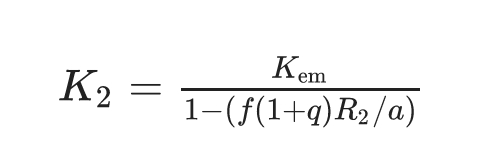

In [101]:
#does kem  matter?

def k2_calc(Kem, q, R2, a, f=0.5):
    """
    Converts the measured K velocity of an emmision line source to a K2 value
    """
    K2 = Kem / (1 - (f*(1+q)*(R2/a)))
    return K2

qmax = maxM2/M1 

k2test = k2_calc(kem, qmin, maxR2*u.Rsun, maxa.to(u.Rsun), f=0.5)
print(k2test)
print(kem)
print(k2test/kem)

#maybe need to get R from model fit?




NameError: name 'qmin' is not defined

In [ ]:
m2new = (k1/k2test) * M1 
print(m2new)

In [ ]:
(maxR2*u.Rsun)/maxa.to(u.Rsun)

In [ ]:
n=0
nsteps = 10000
k2s = [kem]
qs = [qmax]


q = qmax
a = maxa
r2 = maxR2


while n < nsteps-1:
    # print(q)
    # print(a.to(u.Rsun))
    # print(M1*q)
    k2 = k2_calc(kem, q, r2*u.Rsun, a.to(u.Rsun), f=0.5)
    # print(k2)
    nq = k1/k2

    if abs(nq - q) < 0.0001:
        print('yes')
    q = nq
    qs.append(q)

    a = find_a(M1*u.Msun, (M1*q)*u.Msun, fit_period*u.h)
    r2 = mass_radius(((M1*q)*u.Msun).to(u.Mjup).value, error=False)
    r2 = (r2*u.Rjup).to(u.Rsun).value
    k2s.append(k2)

    n += 1

# plt.plot(np.arange(nsteps), k2s/kem)
plt.plot(np.arange(nsteps), qs)



# print(M1*q)    


Ok looks good, how do I include uncertainties?

In [ ]:
fit_period

In [ ]:
# nsteps= 100

# qs = []
# k2s = []

# kems = np.random.normal(kem, keme, nsteps)
# M1s = np.random.normal(M1, M1e, nsteps)
# k1s = np.random.normal(k1, k1e, nsteps)

# for ki in kems:
#     for M1i in M1s:
#         for k1i in k1s:
#             q = k1i/ki
#             a = find_a(M1i*u.Msun, (M1i*q)*u.Msun, fit_period*u.h)
#             r2 = mass_radius(((M1i*q)*u.Msun).to(u.Mjup).value, error=False)
#             r2 = (r2*u.Rjup).to(u.Rsun).value
#             diff = 1000
#             n = 0
#             while diff > 0.0001 and n < 100:
#                 n +=1
#                 k2 = k2_calc(ki, q, r2*u.Rsun, a.to(u.Rsun), f=0.5)
#                 nq = k1i/k2 
#                 diff = abs(nq -q)
#                 q = nq
#                 a = find_a(M1i*u.Msun, (M1i*q)*u.Msun, fit_period*u.h)
#                 r2 = mass_radius(((M1i*q)*u.Msun).to(u.Mjup).value, error=False)
#                 r2 = (r2*u.Rjup).to(u.Rsun).value
#             # print(n)
#             qs.append(q)
#             k2s.append(k2)
    
                
# plt.hist(qs)

# plt.show()
# qmean = np.mean(qs)
# qmed = np.median(qs)
# qstd = np.std(qs)
# print(qmean, qmed, qstd)

# plt.hist(k2s)

# k2mean = np.mean(k2s)
# k2med = np.median(k2s)
# k2std = np.std(k2s)
# print(k2mean, k2med, k2std)


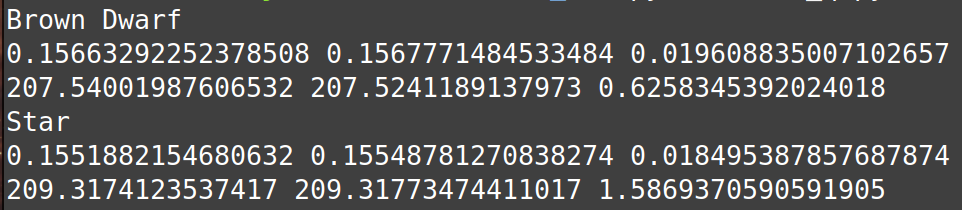

2026  
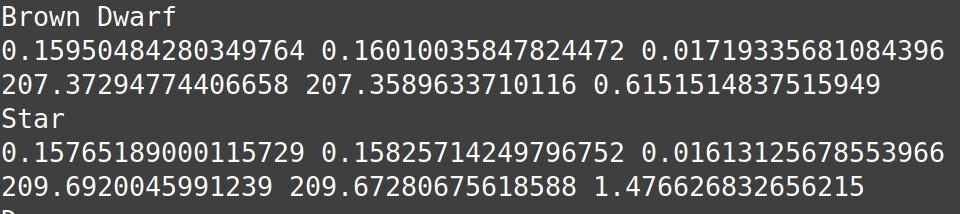

In [ ]:
#from find_q.py
# q, qe = 0.157, 0.020
# k2, k2e = 207.5, 0.63
#2026 update wth new m1
# M1, M1e = 0.49, 0.05
q, qe = 0.16, 0.017


In [ ]:
#BD parameters:

M2 = q * M1
M2e = M2 * ((qe/q)**2 + (M1e/M1)**2)**0.5
print(M2, M2e)
print((M2*u.Msun).to(u.Mjup), (M2e*u.Msun).to(u.Mjup).value)
M2j = (M2*u.Msun).to(u.Mjup).value
M2je = (M2e*u.Msun).to(u.Mjup).value
R2 = M2j ** -0.044
# print(R2*u.Rjup)
# print((R2*u.Rjup).to(u.Rsun))
# 0.018
R2e = R2 * (((-0.044/M2j)*M2je)**2 + (np.log(M2j)*0.018)**2)**0.5
print(R2, R2e*u.Rjup)
print((R2*u.Rjup).to(u.Rsun), (R2e*u.Rjup).to(u.Rsun))

a  = find_a(M1*u.Msun, M2*u.Msun, fit_period*u.h)
print(a)
print(a.to(u.Rsun))



Appeal to teff?

In [ ]:
#teq for difference between near and far side
teq = teff *(rwd*u.Rsun / (2*a.to(u.Rsun)))**0.5
print(teq)
#darn that's a bit high. What can we rule out from light curves?

In [ ]:
np.median(wde)

In [ ]:
a

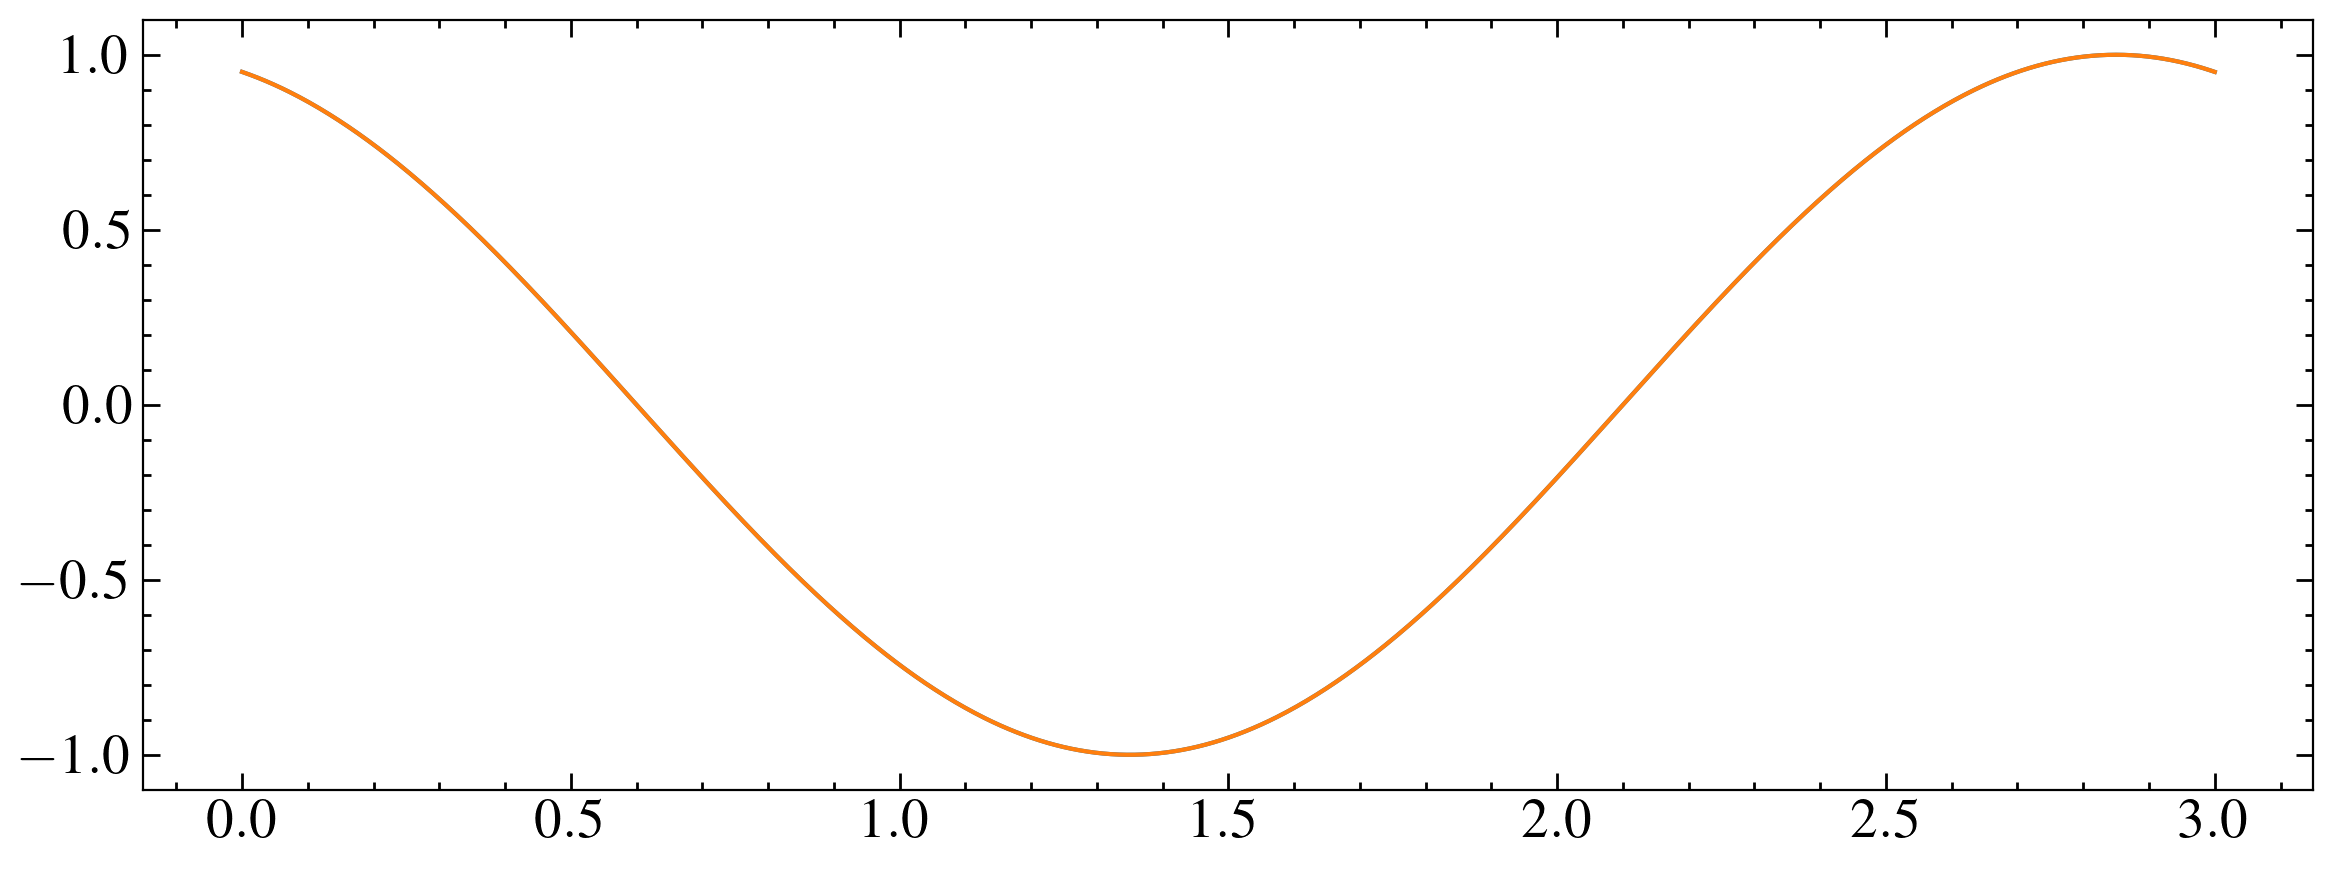

In [195]:
fig, ax = plt.subplots()

mod = models.Sine1D(1, 1/3, 0.3)
x = np.linspace(0, 3, 1000)
ax.plot(x, mod(x))

mod = models.Sine1D(1, 1/3, -0.7)
ax.plot(x, mod(x))
